## DDPG - Reacher

### Set environment

In [1]:
%config IPCompleter.greedy=True
from unityagents import UnityEnvironment
import numpy as np

aws_unity_filename= '/home/ubuntu/deep-reinforcement-learning/p2_continuous-control/Reacher_Linux_NoVis/Reacher.x86_64'
laptop_unity_filename= '/home/mezquita/deep-reinforcement-learning/p2_continuous_control/Reacher_Linux/Reacher.x86_64'
seed= 0 #datetime.now().second
env = UnityEnvironment(seed= seed, file_name= laptop_unity_filename)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

#Handy functions to help understand the code
def env_reset(env, mode=True):
    env_info = env.reset(train_mode=mode)[env.brain_names[0]]
    return env_info.vector_observations[0]

def env_step(env, action):
    env_info= env.step(action)[env.brain_names[0]]
    return env_info.vector_observations[0], env_info.rewards[0], env_info.local_done[0]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### main

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Variable
from collections import deque
from datetime import datetime

from ddpg import DDPG

NUM_EPISODES = 300
SOLVED_IN= 30

start= datetime.now()

state= env_reset(env, True)
# Hyperparameters
config= {
    "label": "Noise",
    "state_size": len(state),
    "action_size": brain.vector_action_space_size,
    "seed": seed,
    "actor_lr": 0.001,
    "critic_lr": 0.001,
    "actor_nodes": [256, 256],
    "critic_nodes": [256, 256],
    "batch_size": 512,
    "memory_size": 100000,
    "discount": 0.9,
    "sigma": 0.1, # OUNoise
    "tau": 0.001,
    "epsilon": 1.0,
    "epsilon_decay": 1e-5,
}


agent = DDPG(config= config)

scores_window = deque(maxlen=100)
solved= False

for episode in range(NUM_EPISODES):
    state= env_reset(env, True)
    agent.reset()
    ep_reward = 0
    score= 0  
    while True:
        action = agent.act(state)
        # Environmet step
        next_state, reward, done= env_step(env, action)
        # Agent step. Includes learnig from memory
        agent.step(state, action, reward, next_state, done)
        
        score+= reward
        state= next_state
        if done: 
            break
    scores_window.append(score)       # save most recent score
    agent.scores.append(score)              # save most recent score
    mean_w_scores= np.mean(scores_window)
    print('\rEpisode {}\tAverage Score: {:.2f}  '.format(episode+ 1, mean_w_scores), end="")
    if (episode+ 1) % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}  '.format(episode+ 1, mean_w_scores))
    if mean_w_scores >= SOLVED_IN:
        if solved== False:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format((episode+ 1)-100, mean_w_scores))
            solved= True
        break
        
agent.save()

print('Elapsed time', datetime.now()- start)
        
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

smoothed_scores= running_mean(agent.scores, 10)
plt.plot(np.arange(len(smoothed_scores)), smoothed_scores)
plt.plot(np.arange(len(agent.scores)), agent.scores, color='grey', alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Reward')


plt.show()


Episode 51	Average Score: 3.55  

### See how the agent behaves

In [10]:
import torch
from ddpg import DDPG

state= env_reset(env, False)
config= {
    "label": "Noise",
    "state_size": len(state),
    "action_size": brain.vector_action_space_size,
    "seed": seed,
    "actor_lr": 0.001,
    "critic_lr": 0.001,
    "actor_nodes": [32, 32],
    "critic_nodes": [256, 256],
    "batch_size": 256,
    "memory_size": 100000,
    "discount": 0.9,
    "sigma": 0.0, # OUNoise
    "tau": 0.001,
    "epsilon": 1.0,
    "epsilon_decay": 1e-5,
}
#agent = DDPG(filename= "DDPG_2018-09-14_19:01:10.data")
agent = DDPG(config= config)
agent.actor.load_state_dict(torch.load("last_actor-nodes-32.pth", map_location=lambda storage, loc: storage))
agent.actor.eval() 

score = 0                                          # initialize the score
while True:
    action = agent.actor(torch.FloatTensor(state).view(1, -1))
    next_state, reward, done= env_step(env, action.detach().numpy())
    
        
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    print('\rScore: {:.1f} '.format(score), end="")
    if done:                                       # exit loop if episode finished
        break
    
print("\rFinal score: {:.1f}".format(score))


Final score: 39.4


### Plot from file

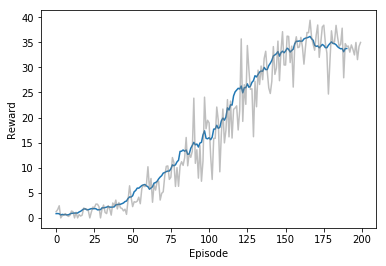

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

data= torch.load("DDPG-200.data", map_location=lambda storage, loc: storage)
scores= data["scores"]

smoothed_scores= running_mean(scores, 10)
plt.plot(np.arange(len(smoothed_scores)), smoothed_scores)
plt.plot(np.arange(len(scores)), scores, color='grey', alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Reward')


plt.show()
  

### Explore directory

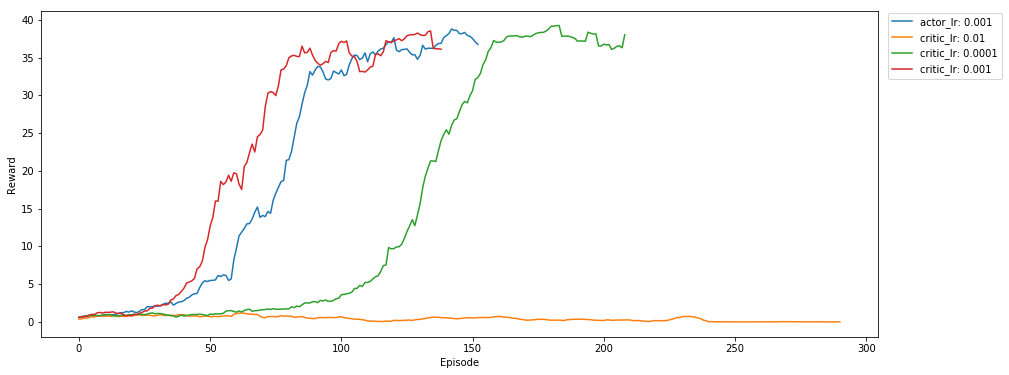

In [2]:
from glob import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N


plt.figure(figsize=(15, 6))

files= glob("*.data")

for file in sorted(glob("*.data")):
    data= torch.load(file, map_location=lambda storage, loc: storage)
    scores= data["scores"]
    smoothed_scores= running_mean(scores, 10)
    # Label
    label= "Unknown"
    if "label" in data["config"]:
        label= "{}: {}".format(data["config"]["label"], data["config"]["critic_lr"])
    plt.plot(np.arange(len(smoothed_scores)), smoothed_scores, label= label)

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()